## Create, evaluate, and score a churn prediction model

### Step 1: Install custom libraries

In [1]:
#%pip install imblearn

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Step 2: Load the data

In [3]:
import os
import requests
import itertools
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from matplotlib import rc, rcParams

In [4]:
sns.set_theme(style="whitegrid", palette="tab10", rc = {'figure.figsize':(9,6)})
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: "{:,.2f}".format(x))

In [5]:
IS_CUSTOM_DATA = False # If TRUE, the dataset has to be uploaded manually

IS_SAMPLE = False # If TRUE; use only SAMPLE_ROWS of data for training, otherwise use all data
SAMPLE_ROWS = 5000 # If IS_SAMPLE is True, use only this number of rows for training

DATA_ROOT = ""
DATA_FOLDER = "/Users/gblasd/Documents/DataScience/02_SupervisedLearning/data/churn" # Folder with data files
DATA_FILE = "churn.csv"


In [6]:
if not IS_CUSTOM_DATA:
# With an Azure Synapse Analytics blob, this can be done in one line

# Download demo data files into the lakehouse if they don't exist
    remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/bankcustomerchurn"
    file_list = ["churn.csv"]
    download_path = "/Users/gblasd/Documents/DataScience/02_SupervisedLearning/data/churn/raw"

    os.makedirs(download_path, exist_ok=True)
    for fname in file_list:
        if not os.path.exists(f"{download_path}/{fname}"):
            r = requests.get(f"{remote_url}/{fname}", timeout=30)
            with open(f"{download_path}/{fname}", "wb") as f:
                f.write(r.content)
    print("Downloaded demo data files into lakehouse.")

Downloaded demo data files into lakehouse.


In [7]:
# Record the notebook running time
import time
ts = time.time()

In [8]:
df = pd.read_csv(DATA_FOLDER + '/' + DATA_FILE)
df.shape

(7043, 21)

### Step 3: Perform exploratory data analysis

#### Display raw data

In [9]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [10]:
display(df.sample(5))

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1744,8952-WCVCD,Female,0,Yes,No,41,Yes,No,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,One year,Yes,Bank transfer (automatic),104.45,4162.05,No
1591,8246-SHFGA,Male,0,No,No,17,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),21.10,385.55,No
5863,7969-AULMZ,Female,0,No,No,21,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,97.35,2119.5,Yes
6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
6326,3249-VHRIP,Female,0,No,No,62,No,No phone service,DSL,No,Yes,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.60,2748.7,No


In [11]:
def clean_data(df):
    # Drop rows with missing data across all columns
    df.dropna(inplace=True)
    # Drop duplicate rows in columns: 'RowNumber', 'CustomerId'
    df.drop_duplicates(subset=['customerID'], inplace=True)
    # Drop columns: 'RowNumber', 'CustomerId', 'Surname'
    # df.drop(columns=['RowNumber', 'CustomerID', 'Surname'], inplace=True)
    return df

df_clean = clean_data(df.copy())


In [12]:
df_clean.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3698,7346-MEDWM,Female,0,No,No,59,Yes,Yes,Fiber optic,No,Yes,Yes,No,No,No,Month-to-month,Yes,Electronic check,83.25,4949.1,No
4139,7278-CKDNC,Male,1,No,No,24,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,80.50,2088.45,No
5410,4049-ZPALD,Female,0,Yes,No,64,Yes,No,Fiber optic,Yes,No,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),99.00,6375.8,No
6749,8469-SNFFH,Male,0,Yes,No,70,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,One year,No,Bank transfer (automatic),79.40,5528.9,No
6027,4896-CPRPF,Male,0,Yes,Yes,35,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),25.45,809.25,No


#### Determine attributes

In [13]:
um =  ['customerID']

# Determine the dependent (target) attribute
dependent_variable_name = "Churn"
print(dependent_variable_name)

# Determine the categorical attributes
categorical_variables = [col for col in df_clean.columns if col in "O"
                        or df_clean[col].nunique() <=5
                        and col not in "Churn"]
print(categorical_variables)

# Determine the numerical attributes
numeric_variables = [col for col in df_clean.columns if df_clean[col].dtype != "object"
                        and df_clean[col].nunique() >5]
print(numeric_variables)

Churn
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
['tenure', 'MonthlyCharges']


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


#### Show the five-number summary

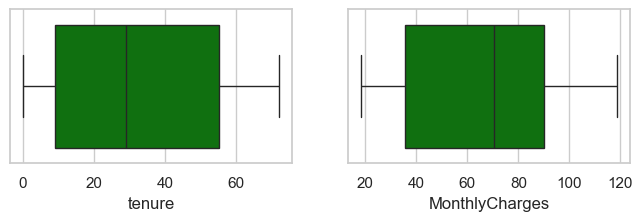

In [15]:
df_num_cols = df_clean[numeric_variables]
fig, axes = plt.subplots(nrows = 1, ncols = 2, gridspec_kw =  dict(hspace=0.3), figsize = (8,2))
fig.tight_layout()
for ax,col in zip(axes.flatten(), df_num_cols.columns):
    sns.boxplot(x = df_num_cols[col], color='green', ax = ax)
# fig.suptitle('visualize and compare the distribution and central tendency of numerical attributes', color = 'k', fontsize = 12)
# fig.delaxes(axes[1,1])

#### Show the distribution of exited and non-exited customers

In [16]:
df_clean[categorical_variables].columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

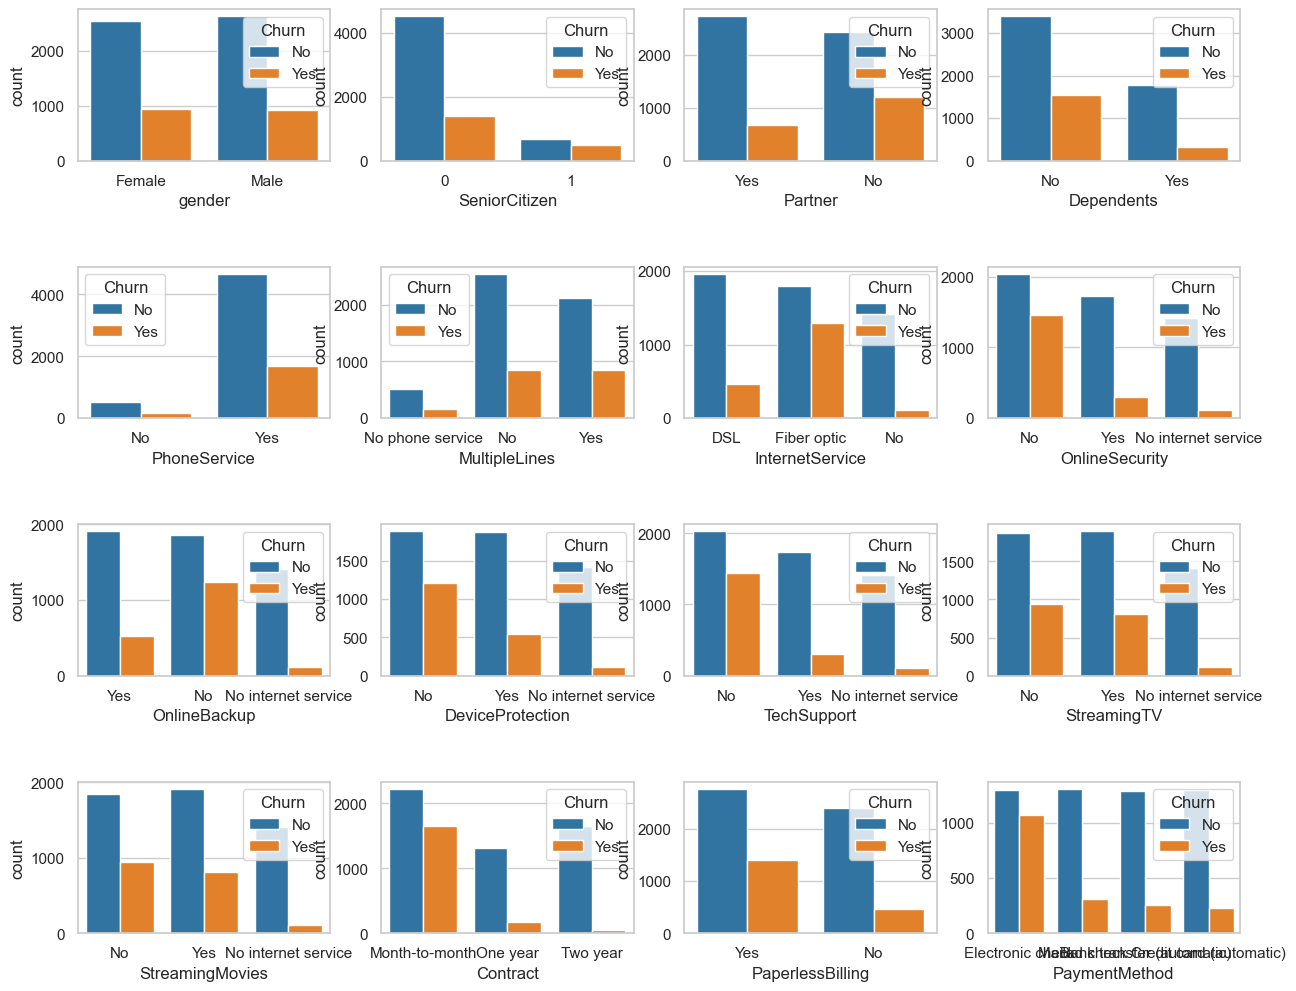

In [17]:
attr_list = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod']
fig, axarr = plt.subplots(4, 4, figsize=(15, 12))
x_gph = 0
y_gph = 0
for ind, item in enumerate (attr_list):
    sns.countplot(x = item, hue = 'Churn', data = df_clean, ax = axarr[x_gph][y_gph])
    if y_gph < 3:
        y_gph += 1
    else:
        y_gph=0
        if x_gph < 3:
            x_gph += 1
        else:
            x_gph = 0
fig.subplots_adjust(hspace=0.7)

#### Show the distribution of numerical attributes

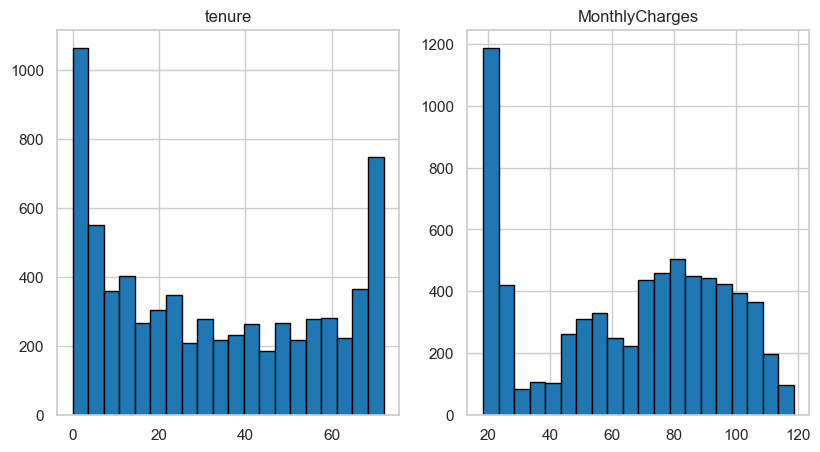

In [18]:
columns = df_num_cols.columns[: len(df_num_cols.columns)]
fig = plt.figure()
fig.set_size_inches(15, 5)
length = len(columns)
for i,j in itertools.zip_longest(columns, range(length)):
    plt.subplot((length // 2), 3, j+1)
    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
    df_num_cols[i].hist(bins = 20, edgecolor = 'black')
    plt.title(i)
# fig = fig.suptitle('distribution of numerical attributes', color = 'r' ,fontsize = 14)
plt.show()

#### Perform engineering

In [19]:
df_clean.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [20]:
#df_clean["NewTenure"] = df_clean["tenure"]/df_clean["Age"]
#df_clean["NewCreditsScore"] = pd.qcut(df_clean['CreditScore'], 6, labels = [1, 2, 3, 4, 5, 6])
#df_clean["NewAgeScore"] = pd.qcut(df_clean['Age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
#df_clean["NewBalanceScore"] = pd.qcut(df_clean['Balance'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
#df_clean["NewEstSalaryScore"] = pd.qcut(df_clean['EstimatedSalary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [21]:
#df_clean = pd.get_dummies(df_clean, columns=['Geography', 'Gender'])

In [22]:
X = df_clean[um+numeric_variables].merge(pd.get_dummies(df_clean[um+categorical_variables], columns=categorical_variables, drop_first=True, dtype=int))

In [44]:
var_predic = [x for x in X.columns.to_list() if x not in ['customerID']]
var_predic

['tenure',
 'MonthlyCharges',
 'gender_Male',
 'SeniorCitizen_1',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

In [46]:
X = X[var_predic]

In [47]:
y = df_clean[dependent_variable_name]

In [48]:
X.head()

,tenure,MonthlyCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,34,56.95,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,2,53.85,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,45,42.30,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
4,2,70.70,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [49]:
y.head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: Churn, dtype: object

### Step 4: Perform model training and tracking

In [27]:
# brew install lightgbm

In [26]:
# Import the required libraries for model training
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score, roc_auc_score, classification_report

#### Prepare training and test datasets

In [50]:
# Train/test separation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

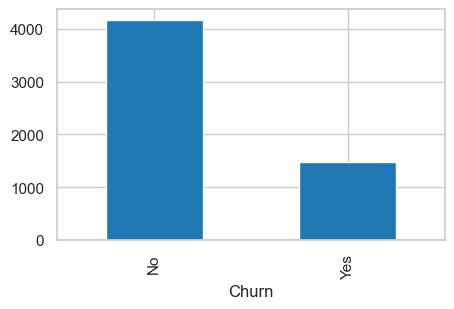

In [51]:
plt.figure(figsize=(5, 3))
y_train.value_counts().plot(kind='bar')
plt.show()

#### Apply SMOTE to the training data

In [52]:
from collections import Counter
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=123)

X_res, y_res = sm.fit_resample(X_train, y_train)

new_train = pd.concat([X_res, y_res], axis=1)

In [53]:
new_train.sample(3)

,tenure,MonthlyCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
6192,42,104.03,0,1,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,Yes
6904,4,84.55,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,Yes
4308,33,24.15,0,0,1,1,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,No


#### Train the model

In [62]:
rfc1_sm = RandomForestClassifier(max_depth=4, max_features=4, min_samples_split=3, random_state=1) # Pass hyperparameters
# Balanced training data
rfc1_sm.fit(X_res, y_res.ravel()) 
rfc1_sm.score(X_test, y_test)
y_pred = rfc1_sm.predict(X_test)
cr_rfc1_sm = classification_report(y_test, y_pred)
cm_rfc1_sm = confusion_matrix(y_test, y_pred)
roc_auc_rfc1_sm = roc_auc_score(y_res, rfc1_sm.predict_proba(X_res)[:, 1])
y_pred_rfc1_sm = y_pred

In [63]:
rfc2_sm = RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3, random_state=1) # Pass hyperparameters
# Balanced training data
rfc2_sm.fit(X_res, y_res.ravel()) 
rfc2_sm.score(X_test, y_test)
y_pred = rfc2_sm.predict(X_test)
cr_rfc2_sm = classification_report(y_test, y_pred)
cm_rfc2_sm = confusion_matrix(y_test, y_pred)
roc_auc_rfc2_sm = roc_auc_score(y_res, rfc2_sm.predict_proba(X_res)[:, 1])
y_pred_rfc2_sm = y_pred

In [57]:
# lgbm_model
lgbm_sm_model = LGBMClassifier(learning_rate = 0.07, 
                        max_delta_step = 2, 
                        n_estimators = 100,
                        max_depth = 10, 
                        eval_metric = "logloss", 
                        objective='binary', 
                        random_state=42)

lgbm_sm_model.fit(X_res, y_res.ravel()) # Balanced training data
y_pred = lgbm_sm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
cr_lgbm_sm = classification_report(y_test, y_pred)
cm_lgbm_sm = confusion_matrix(y_test, y_pred)
roc_auc_lgbm_sm = roc_auc_score(y_res, lgbm_sm_model.predict_proba(X_res)[:, 1])

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 4159, number of negative: 4159
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 382
[LightGBM] [Info] Number of data points in the train set: 8318, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric


### Step 5: Evaluate and save the final machine learning model

In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    print(cm)
    plt.figure(figsize=(4,4))
    plt.rcParams.update({'font.size': 10})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[760 255]
 [ 98 296]]


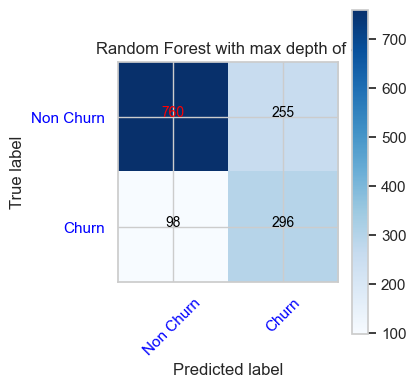

In [66]:
cfm = confusion_matrix(y_test, y_pred=y_pred_rfc1_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Random Forest with max depth of 4')
tn, fp, fn, tp = cfm.ravel()

[[792 223]
 [110 284]]


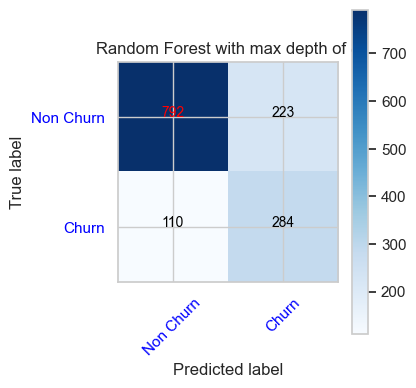

In [67]:
cfm = confusion_matrix(y_test, y_pred=y_pred_rfc2_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Random Forest with max depth of 8')
tn, fp, fn, tp = cfm.ravel()

[[792 223]
 [110 284]]


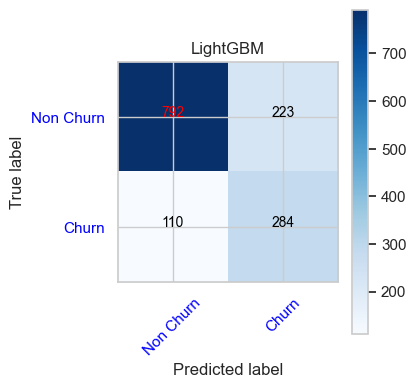

In [68]:
cfm = confusion_matrix(y_test, y_pred=y_pred_rfc2_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='LightGBM')
tn, fp, fn, tp = cfm.ravel()

In [ ]:
# https://github.com/microsoft/fabric-samples/blob/main/docs-samples/data-science/ai-samples/python/AIsample%20-%20Bank%20Customer%20Churn.ipynb